# Implementing Differentiable IIR in PyTorch

In this section, we will implement the methods we have discussed in the section [Differentiable Implementation of IIR Filters](iir_impl.md). We encourage the readers to read that section first to get a better understanding of the methods we will implement here.

Below are some high-level functions that we will be using in this section. 

- [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)
- [torch.jit.script](https://pytorch.org/docs/stable/generated/torch.jit.script.html)
- [torch.autograd.Function](https://pytorch.org/docs/stable/autograd.html#function)

## Naive IIR Implementation

Before we start, let us import the necessary libraries and define some helper functions for plotting.

In [1]:
import torch
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from timeit import timeit
from torch.profiler import profile, ProfilerActivity

In [2]:
def plot_tf(
    title: str,
    fs: int,
    t: np.ndarray,
    ys: List[np.ndarray],
    labels: List[str] = None,
    xlim: Tuple[float, float] = None,
):
    fig = plt.figure(figsize=(12, 5), dpi=200)
    plt.subplot(1, 2, 1)
    for y, label in zip(ys, labels) if labels is not None else zip(ys, [None] * len(ys)):
        plt.plot(t, y, label=label)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(title)
    if label is not None:
        plt.legend()
    if xlim is not None:
        plt.xlim(*xlim)
    plt.subplot(1, 2, 2)
    for y, label in zip(ys, labels) if labels is not None else zip(ys, [None] * len(ys)):
        plt.magnitude_spectrum(y, Fs=fs, scale="dB", window=signal.windows.boxcar(len(y)), label=label)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB]")
    plt.xscale("log")
    plt.ylim(-60, 10)
    plt.title("Magnitude spectrum")
    if labels is not None:
        plt.legend()
    plt.show()

Let us first implement an IIR filter in PyTorch using the difference equation {eq}`iir` directly and see how it performs. 

In [3]:
@torch.jit.script
def naive_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Naive implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # apply initial rest condition
    # here, we use the utility function `new_zeros` to create a tensor
    # with the same dtype and device as `x` filled with zeros, so we
    # don't have to worry and create variables for the dtype and device
    y = [x.new_zeros(1)] * M
    for i in range(T):
        past_outputs = torch.cat(y[-1:-M-1:-1])
        y.append(x[i:i+1] -torch.dot(a, past_outputs))
    return torch.cat(y[M:])

For simplicity, the above implementation assumes $y[n] = 0$ for $n < 0$. In addition, We use the `torch.jit.script` decorator to utilise just-in-time compilation for speed improvement. Let us check whether the implementation is correct by comparing it with the `scipy.signal.lfilter` function.

The test signal is a chirp signal with a frequency that increases linearly from 1 Hz to 1000 Hz in 2 seconds. The sampling rate is 16000 Hz.

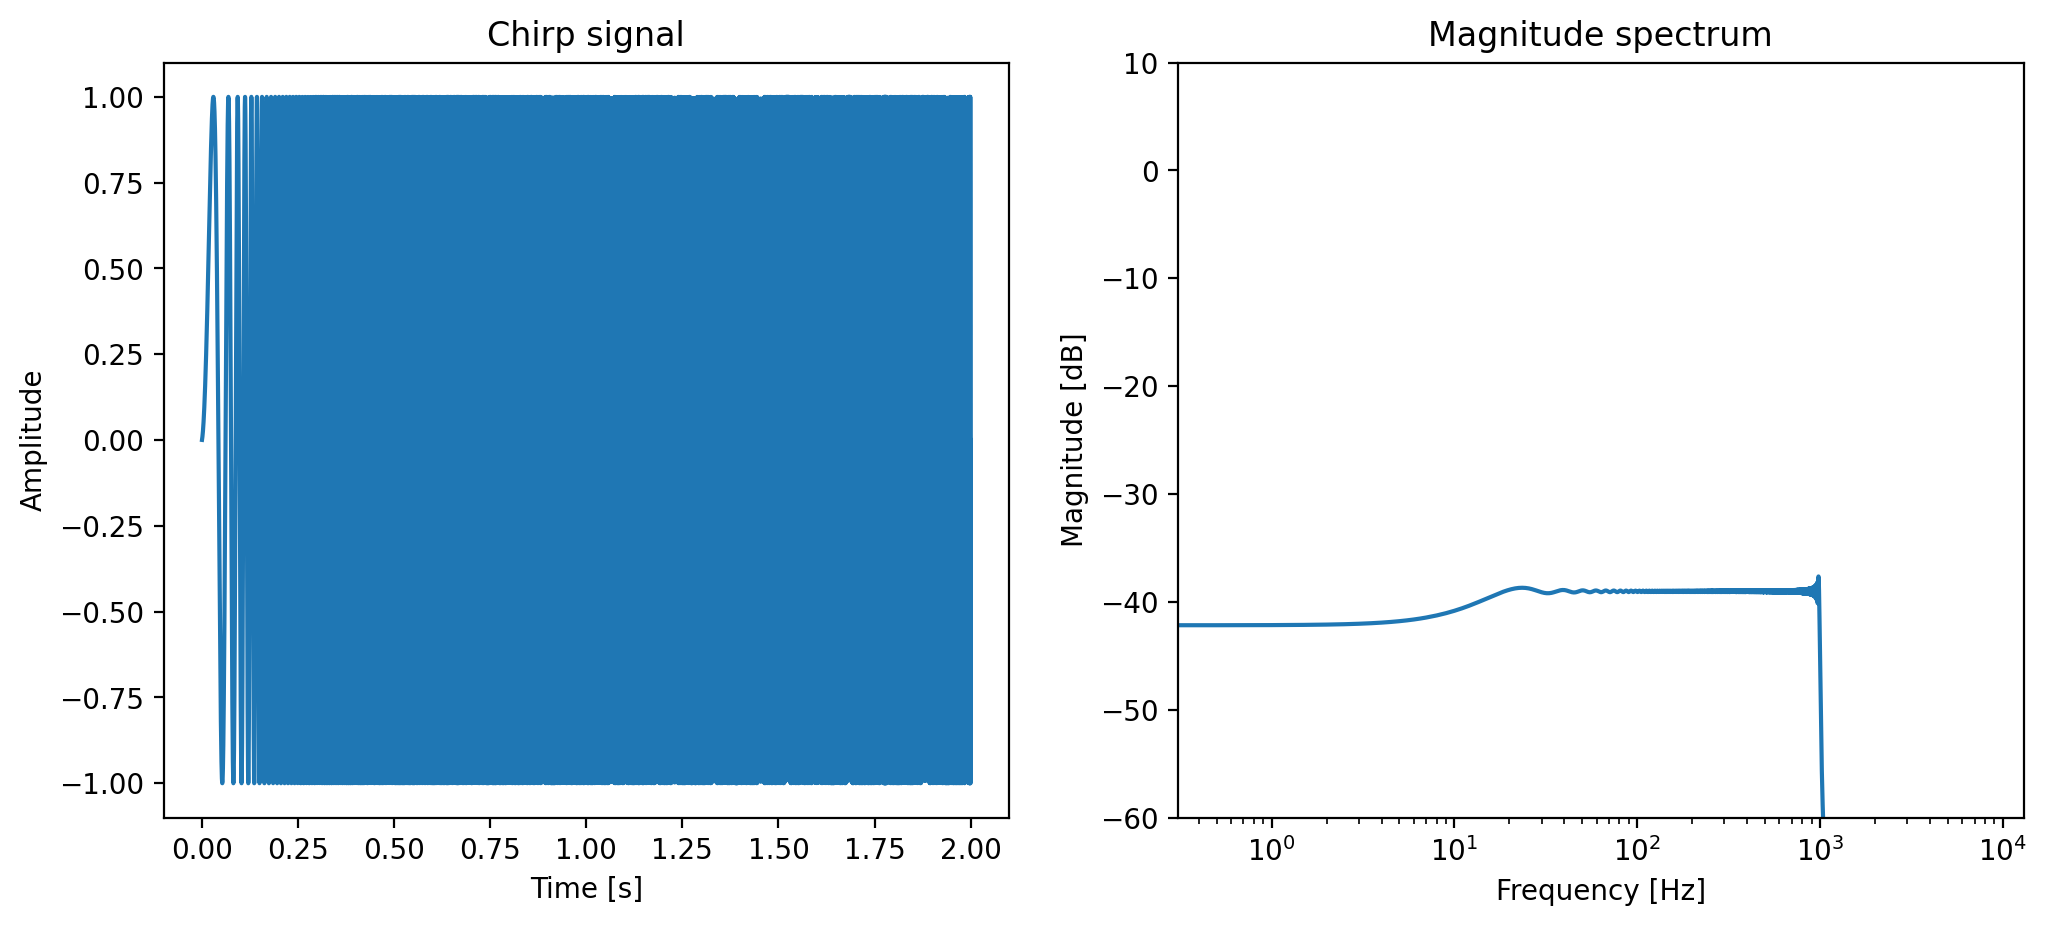

In [4]:
def chirp(T: int, start_freq: float, end_freq: float, fs: float):
    """
    Generate chirp signal.
    """
    angular_freq = np.linspace(start_freq, end_freq, T) / fs
    phase = np.cumsum(angular_freq)
    return np.sin(2 * np.pi * phase)

fs = 16000
T = 16000 * 2
start_freq = 1
end_freq = 1000
test_signal = chirp(T, start_freq, end_freq, fs)

plot_tf("Chirp signal", fs, np.arange(T) / fs, [test_signal])

The filter we use is a second-order low pass filter ($M$ = 2) with coefficients $a_1 = -1.8$ and $a_2 = 0.81$. Let us see how the filter performs on the chirp signal.

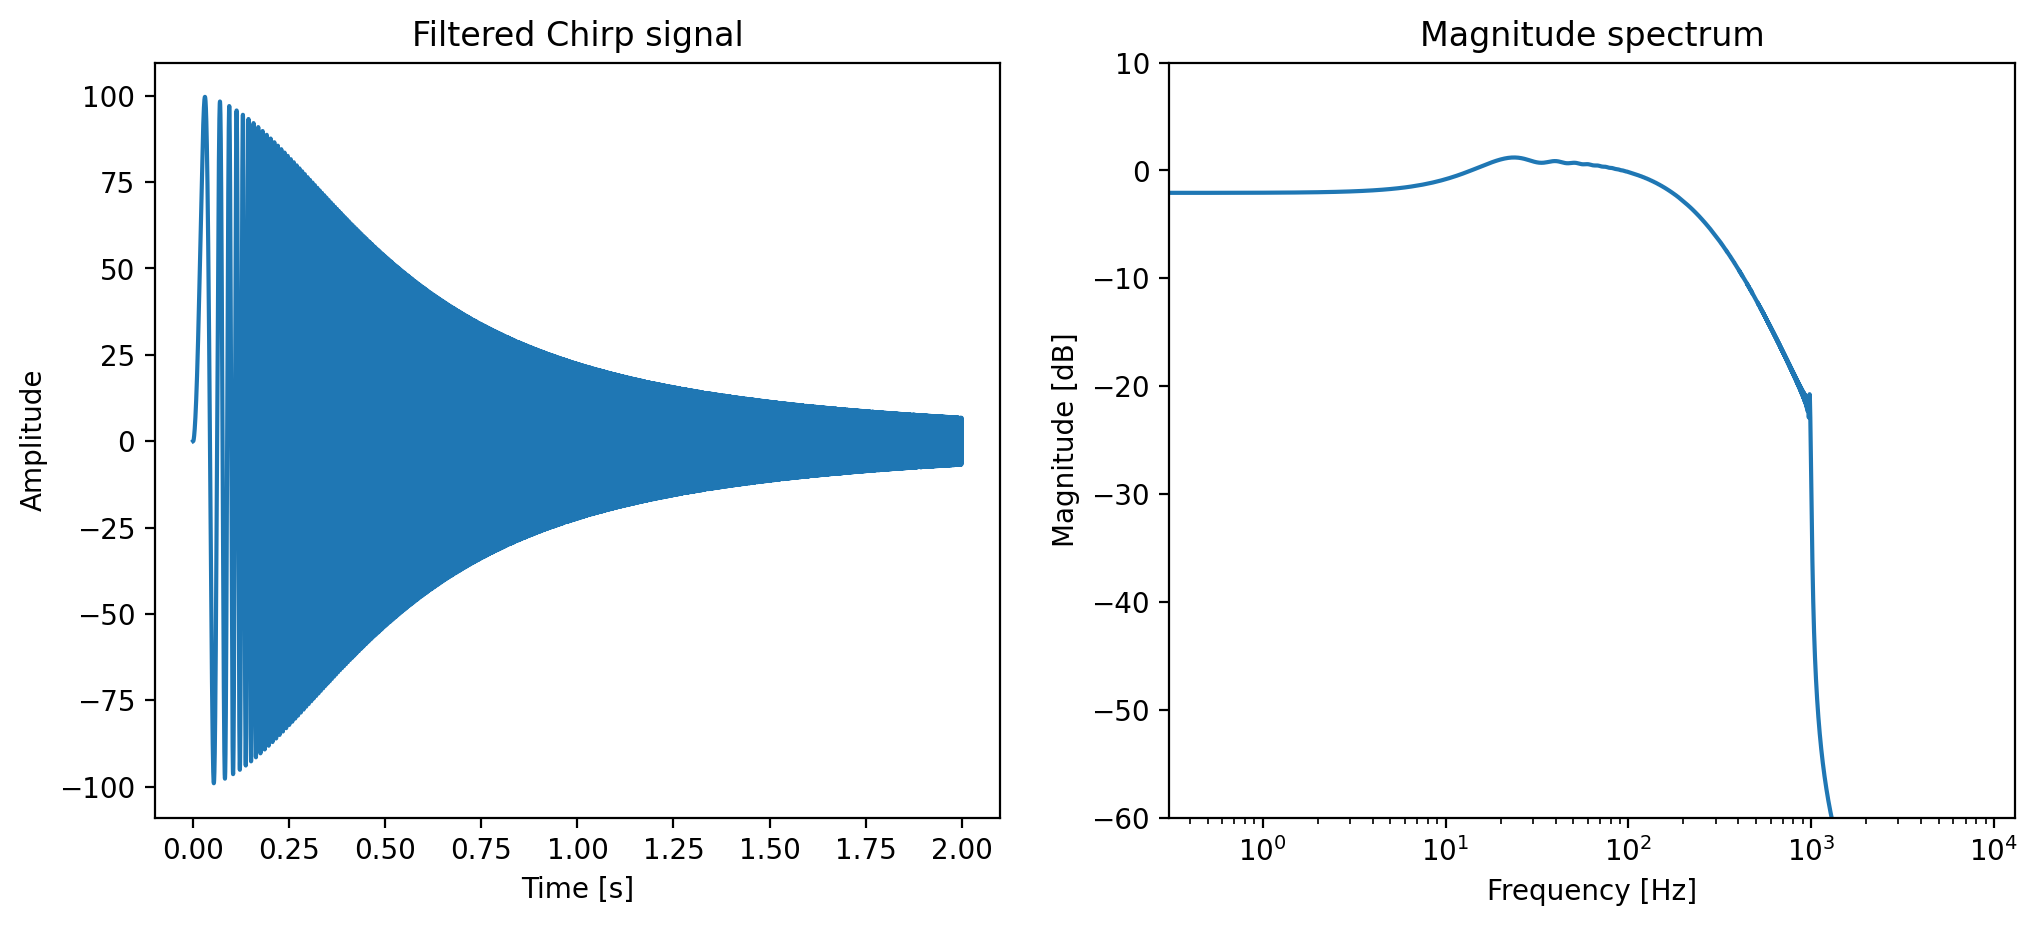

In [5]:
b = [1, 0]
a = [1, -0.9 * 2, 0.9 ** 2]
filtered_signal = signal.lfilter(b, a, test_signal)

plot_tf("Filtered Chirp signal", fs, np.arange(T) / fs, [filtered_signal])

Is our PyTorch implementation correct? Let us compare it with the `scipy.signal.lfilter` function.

In [6]:
a_torch = torch.tensor(a[1:], dtype=torch.float64)
test_signal_torch = torch.tensor(test_signal, dtype=torch.float64)
filtered_signal_torch = naive_iir(test_signal_torch, a_torch)

torch.allclose(filtered_signal_torch, torch.from_numpy(filtered_signal))

True

Horay! It pass the test. Let us now see how fast it is.

In [7]:
scipy_time = timeit(
    stmt="signal.lfilter(b, a, test_signal)", setup="from scipy import signal", 
    globals={
        "b": b,
        "a": a,
        "test_signal": test_signal
    },
    number=1000
) / 1000

torch_time = timeit(
    stmt="naive_iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "naive_iir": naive_iir
    },
    number=10
) / 10

print(f"scipy.signal.lfilter: {scipy_time:.5f} [s]")
print(f"naive_iir: {torch_time:.4f} [s]")

scipy.signal.lfilter: 0.00027 [s]
naive_iir: 0.2904 [s]


The direct implementation is roughly 1000 times slower than the `scipy.signal.lfilter` function! What is the reason? One reason is that the core part of `scipy.signal.lfilter` is implemented in C and is highly optimised. Let us use `torch.profiler` to profile the code and see if we can make our implementation faster.

In [8]:
with profile(activities=[ProfilerActivity.CPU]) as prof:
    naive_iir(test_signal_torch[:], a_torch)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
           naive_iir        34.96%     150.369ms        99.99%     430.041ms     430.041ms             1  
           aten::cat        17.87%      76.851ms        17.87%      76.851ms       2.402us         32001  
           aten::dot        15.93%      68.506ms        16.36%      70.378ms       2.199us         32000  
         aten::slice        15.38%      66.145ms        15.49%      66.599ms       2.081us         32001  
           aten::sub        15.31%      65.842ms        15.31%      65.842ms       2.058us         32000  
         aten::empty         0.42%       1.793ms         0.42%       1.793ms       0.056us         32001  
    aten::as_strided         0.11%   

The above table shows that a lot of CPU time were spent on `aten:sub`, `aten::cat`, and `aten::dot`. These operations are not optimised for small tensors, but we call them in each loop. In addition, each operation creates a new tensor, and with more than ten thousands of loops, the memory allocations becomes a bottleneck. We recommend readers to check [issue 1238](https://github.com/pytorch/audio/issues/1238) of TorchAudio for more details on this.

One thing we can do is to first allocate a tensor for all the past output samples and reuse it in each loop. This will reduce the number of memory allocations. Let us see how much faster it is.

In [9]:
@torch.jit.script
def inplace_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Inplace implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # allocate memory for output
    y = x.new_zeros(M + T)
    y[M:] = x
    a_flip = a.flip(0)
    for i in range(T):
        past_outputs = y[i:i+M]
        y[i+M] -= torch.dot(a_flip, past_outputs)
    return y[M:]

In [10]:
assert torch.allclose(inplace_iir(test_signal_torch, a_torch), torch.from_numpy(filtered_signal))

torch_time = timeit(
    stmt="iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "iir": inplace_iir
    },
    number=10
) / 10

print(f"inplace_iir: {torch_time:.4f} [s]")

inplace_iir: 0.2045 [s]


We reduce around 20% of the CPU time! However, it is still much slower than the scipy counterpart. The remaining time are mostly related to the framework overhead and cannot be further reduced using the Python frontend.

Moreover, if you backpropagate the gradient through `inplace_iir`, it will throw a runtime error. PyTorch has very limited support in autograd for [inplace operations](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd). In our case, this limits calcaulating the gradients with respect to the filter coefficients (if you set `requires_grad=False` in the first line of the following code block, it will work). This issue was raised in the early version of TorchAudio (<0.9). For interested readers, you can check [issue 704](https://github.com/pytorch/audio/issues/704) to know more history about this.

In [11]:
a_torch_params = a_torch.clone().requires_grad_(True) # try setting this line to false, and see what happens
test_signal_torch_params = test_signal_torch.clone().requires_grad_(True)

filtered_signal_torch_params = inplace_iir(test_signal_torch_params, a_torch_params)
loss = torch.sum(filtered_signal_torch_params.abs())

try:
    loss.backward()
except RuntimeError as e:
    print(e)
else:
    print("No error!")

one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor [2]], which is output 0 of AsStridedBackward0, is at version 32001; expected version 32000 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).


## Differentiable IIR using Frequency Sampling

Let us make another version of the IIR function that uses the frequency sampling method to compute the output samples.

In [12]:
@torch.jit.script
def freq_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Frequency sampling of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    X = torch.fft.rfft(x)
    A = torch.fft.rfft(torch.cat([a.new_ones(1), a]), n=T)
    mag = torch.abs(A)
    phase = torch.angle(A)
    H = torch.nan_to_num(mag.reciprocal()) * torch.exp(-1j * phase)
    Y = X * H
    y = torch.fft.irfft(Y)
    return y

def get_fir_from_iir(a: torch.Tensor, n: int):
    """
    Get FIR filter from IIR filter.
    """
    assert a.ndim == 1
    A = torch.fft.rfft(torch.cat([a.new_ones(1), a]), n=n)
    mag = torch.abs(A)
    phase = torch.angle(A)
    H = torch.nan_to_num(mag.reciprocal()) * torch.exp(-1j * phase)
    h = torch.fft.irfft(H)
    return h

Is the filtered signal the same? False


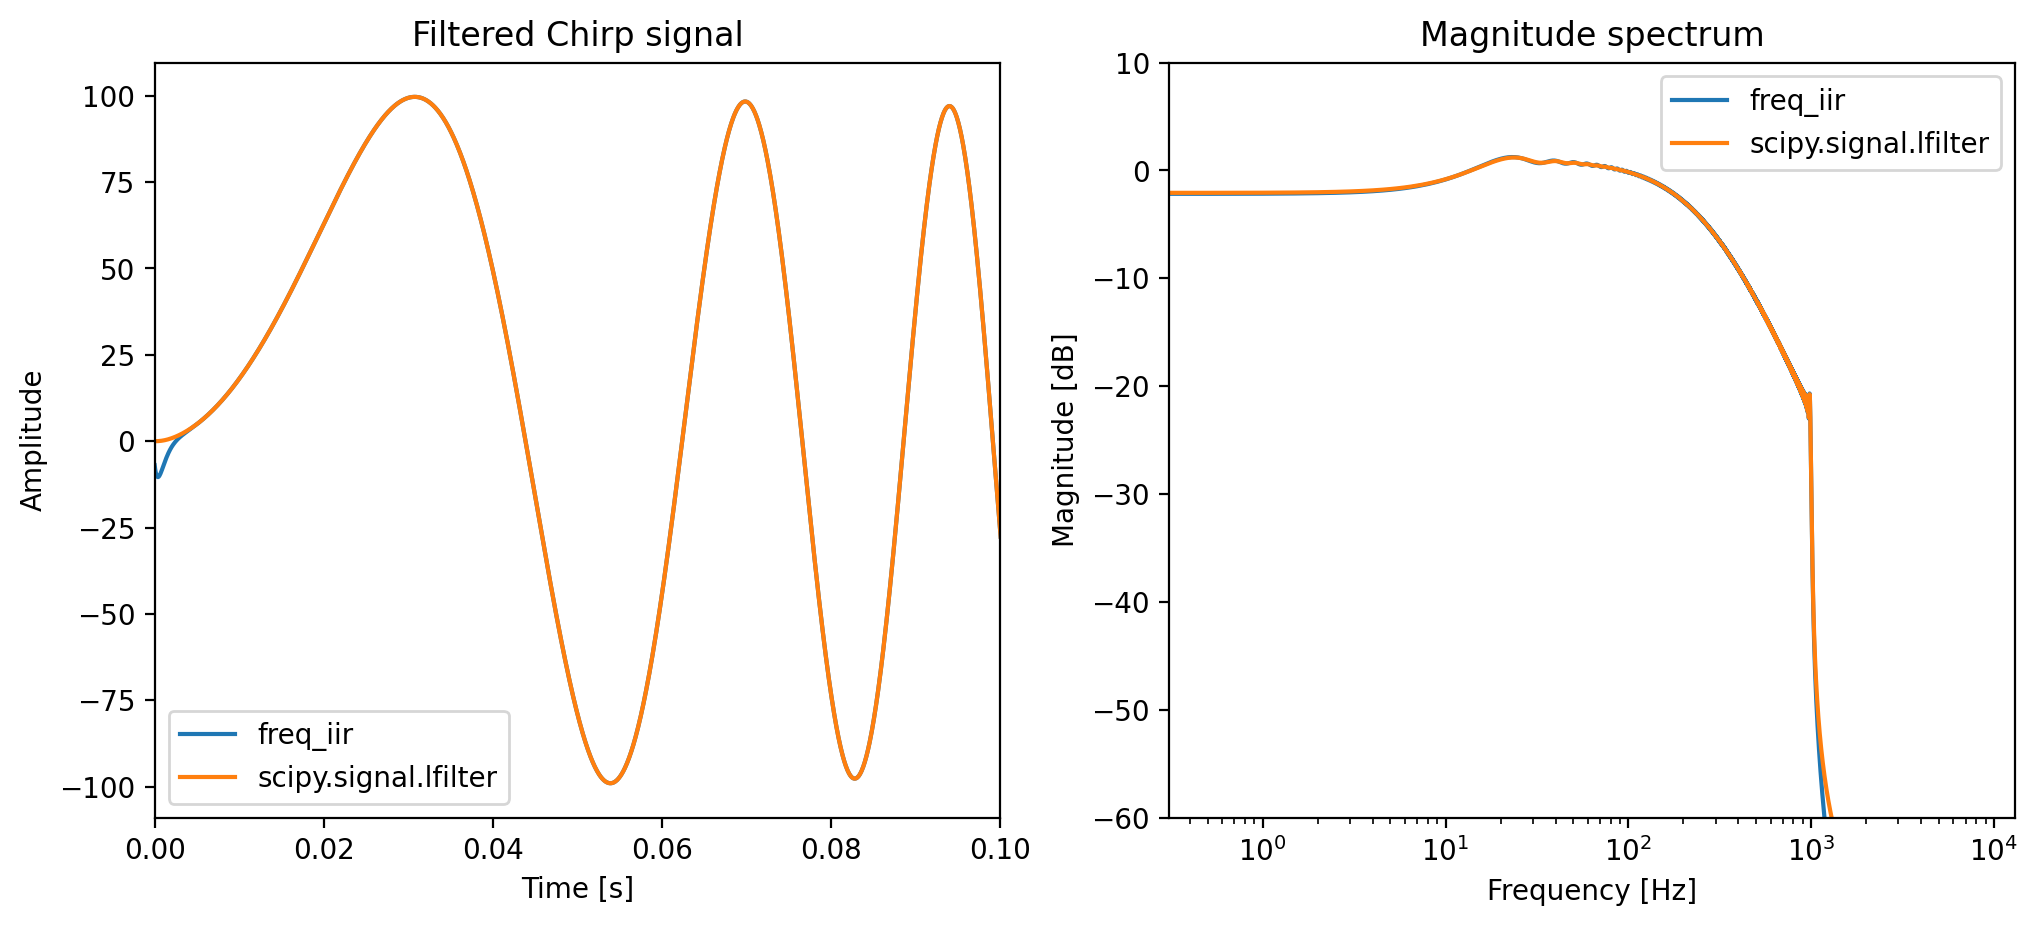

In [13]:
filtered_signal_freq = freq_iir(test_signal_torch, a_torch)

print(
    f"Is the filtered signal the same? {torch.allclose(filtered_signal_freq, torch.from_numpy(filtered_signal))}"
)

plot_tf(
    "Filtered Chirp signal",
    fs,
    np.arange(T) / fs,
    [filtered_signal_freq.numpy(), filtered_signal],
    ["freq_iir", "scipy.signal.lfilter"],
    xlim=(0, 0.1),
)

The above code shows that this approximation does not generate the same output. Although the frequency response looks very close to the original, it does not pass the test. This is because performing the discrete time Fourier transform (DFT) of IIR system equals sampling the system response on discrete frequencies, thus truncate the infinity impulse response to the same length FFT. 
If you need some refreshment on this topic, you can revisit the section [](content:freq-sampling).
Below is the truncated $h_k$ we used in the above example. The sampling process also makes $h_k$ become periodic, so the outputs is actually a circular convolution of the input and $h_k$. This difference is most obvious in our filtered signal at $t \to 0$.

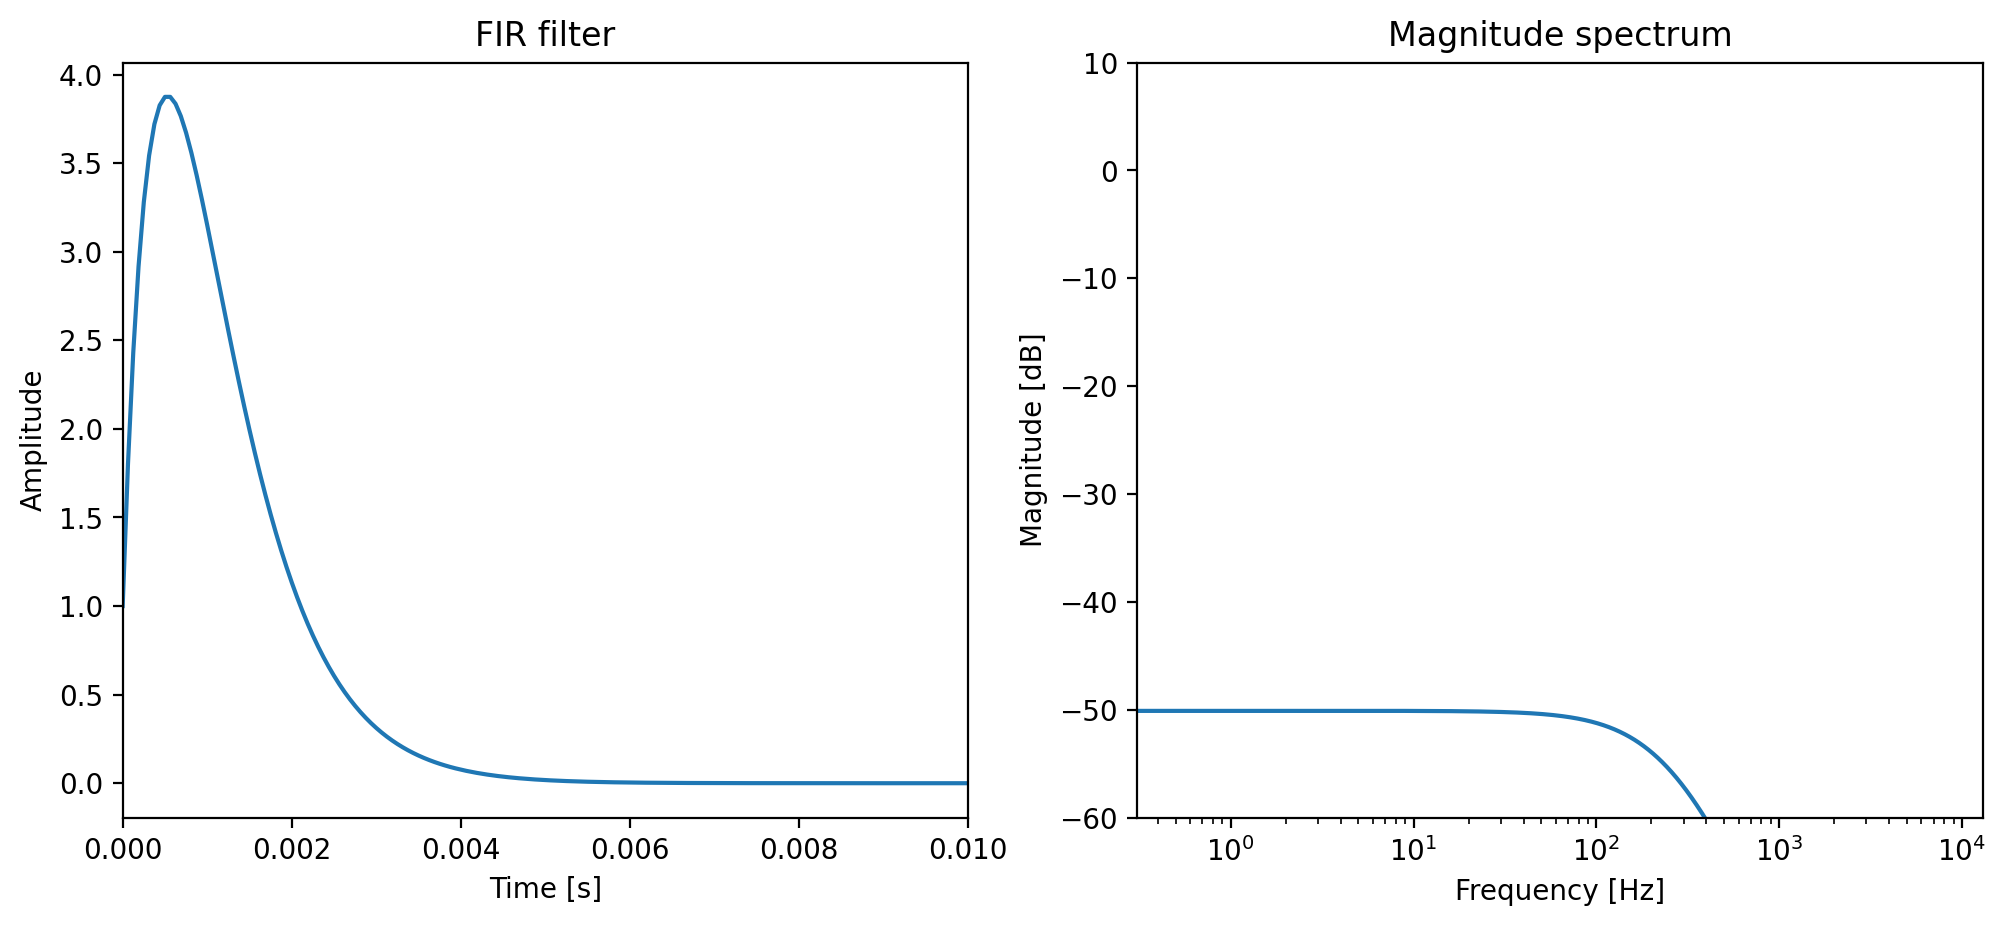

In [14]:
h = get_fir_from_iir(a_torch, T)

plot_tf("FIR filter", fs, np.arange(T) / fs, [h.numpy()], xlim=(0, 0.01))

Let us benchmark the performance of this approximation.

In [15]:
torch_time = timeit(
    stmt="iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "iir": freq_iir
    },
    number=100
) / 100

print(f"freq_iir: {torch_time:.4f} [s]")

freq_iir: 0.0022 [s]


Uohhhhhh! It is super duper fast! Although it is still slower than the `scipy.signal.lfilter` function, it is much faster than the direct implementation. In addition, it is differentiable and can be used in gradient-based methods. Moreover, in many cases, we only care about the frequency response of the filter and not its convolution result. You can compute the loss on the transfer function directly without converting it back to the time domain. Although FFT needs more memory than the direct implementation, the gain in speed outweighs the memory cost.

## Custom Backward Method

To define a custom operator in PyTorch, we have to use the `torch.autograd.Function` class. The `forward` method defines how to compute the output from the input, and the `backward` method defines how to compute the gradient of the loss with respect to the input. After defining the custom operator, we can use by calling its class method `apply` (not the `forward` method!).

In [16]:
class IIR(torch.autograd.Function):
    """
    IIR filter as a torch.autograd.Function.
    """
    @staticmethod
    def forward(ctx, x: torch.Tensor, a: torch.Tensor):
        assert x.ndim == 1
        assert a.ndim == 1
        M = a.numel()

        assert x.is_cpu & a.is_cpu, "Sorry, CPU only for now :("

        a_scipy = [1] + a.numpy().tolist()
        y_scipy = signal.lfilter([1] + [0] * M, a_scipy, x.numpy())
        y = torch.from_numpy(y_scipy).to(x.dtype)

        # remember to save necessary tensors for backward pass
        ctx.save_for_backward(a, y)
        return y

    @staticmethod
    def backward(ctx, y_grad: torch.Tensor):
        a, y = ctx.saved_tensors
        M = a.numel()
        T = y.numel()

        # compute gradient wrt a
        shift_y = torch.cat([y.new_zeros(M), y[:-1]])
        dyda = IIR.apply(-shift_y, a).unfold(0, T, 1).flip(0)
        a_grad = dyda @ y_grad

        # compute gradient wrt x
        x_grad = IIR.apply(y_grad.flip(0), a).flip(0)
        return x_grad, a_grad

In the above sample, we reuse `scipy.signal.lfilter` as our core runner as writing native C++ would be too much in this short notebook :) Another option is to use [Numba](https://numba.pydata.org/) to write the core function in Python and compile it to machine code. Numba also support CUDA and can be used to write GPU kernels. Noting that we call `IIR.apply` inside `backward` instead of `scipy.signal.lfilter`. Why? PyTorch by default does not disable gradient computation for the backward pass, which means the backward computational graph is differentiable **if we use differentiable operators inside `backward`**. The benefit of this is we can get the second order gradient by backpropagating the gradient through the backward pass, and get the third order gradient by backpropagating through the backward pass of the backward ... you got the idea.
Higher order gradient is useful in some applications, and as implementers, it is always good to provide the option for potential users. 

Let us check if our custom backward method is correct using `torch.autograd.gradcheck` and `torch.autograd.gradgradcheck`. This is important as we want to make sure the gradient is correct before using it in our model.

In [17]:
assert torch.autograd.gradcheck(IIR.apply, (test_signal_torch_params[:1000], a_torch_params))
assert torch.autograd.gradgradcheck(IIR.apply, (test_signal_torch_params[:1000], a_torch_params))

Congratulations! We have successfully implemented a differentiable IIR filter that is at least as fast as the `scipy.signal.lfilter` function. You can use it in your model and backpropagate the gradient through it. In the next notebook, we are going to look at some examples on using differentiable IIR filters.

## Additional Resources

Although we have just walked step-by-step through the implementation of a differentiable IIR filter, there are already some implementations available online thanks to the open-source community. Here are some of them:

- [torchaudio.functional.lfilter](https://pytorch.org/audio/stable/generated/torchaudio.functional.lfilter.html#torchaudio.functional.lfilter): you can imagine this as a PyTorch version of `scipy.signal.lfilter`. It is implemented in C++ and CUDA and is highly optimised.
- [torchlpc](https://github.com/yoyololicon/torchlpc): The implementations we have discussed so far only consider the case of time-invartiant IIR filters. This library implements the custom backward method and extends it to time-varying IIR filters.
- [diffsptk.AllPoleDigitalFilter](https://sp-nitech.github.io/diffsptk/1.0.1/core/poledf.html#diffsptk.AllPoleDigitalFilter): `diffsptk` is a differentiable version of the well-known speech processing toolkit, and it also provides a differentiable All-Pole filter, which actually depends on `torchlpc`.